# FuelProphet model

Need this code for installing packages in kivy garden
chmod a+x .venv/bin/garden
python -m pip install https://github.com/kivy-garden/matplotlib/archive/master.zip

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_nico.nico_fuelprophet import FuelProphet
from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, print_model, split_data,prophet_model

/Users/nicoschreiber/Desktop/Neue_Fische/Python/FuelProphet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load data
df = load_data("../data/fueldata/wertheim_23-25.parquet") # Load fuel data
#df = pd.read_parquet("..data/appdata/dailydata/alldata_2025-06-18.parquet")

# Reduce data
df = df[df["datetime"] >= pd.to_datetime("2025-01-01")]
df = df[df["station_uuid"] == "fb0f8030-c1eb-4df1-9410-054eea7422ad"]

In [3]:
# Initialization
b0 = np.array([0.15,0.08,0.06,0.04,0.02,0.55,0.1]) # Can be randomly chosen. Is useless if model.fit_pacf is used
features = [-1,-2,-3,-4,-5,-288,-(7*288)]

# Split data
train,test = split_data(df,interval="2025-05-01")

In [4]:
# Setup model
model = FuelProphet(b0=b0,features=features)
model.fit_pacf(train,threshold=0.2)
model.normalize()
pred = model.predict(X=train,num_predictions=288*3)
print(model.b)
print(model.features)

[0.00949289 0.05324024 0.63570247 0.30156439]
[  -1  -24 -288 -576]


In [5]:
df.columns

Index(['station_uuid', 'name', 'datetime', 'e5'], dtype='object')

/Users/nicoschreiber/Desktop/Neue_Fische/Python/FuelProphet/functions_nico/nico_models.py:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


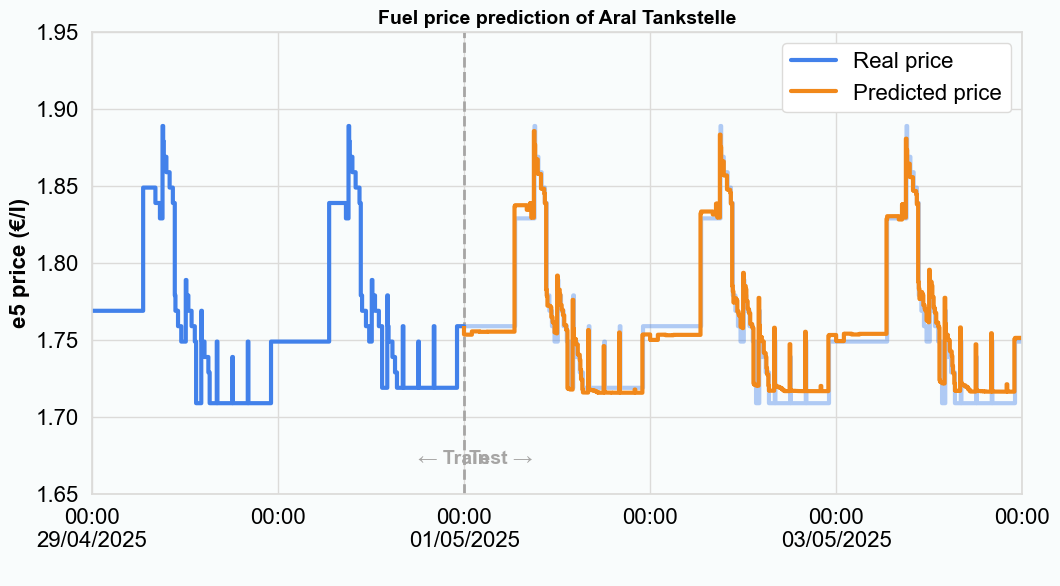

RMSE: 0.012
MAE: 0.007
R2: 0.926


In [6]:
# Print model results
params = {"background":"#f9fcfc",
          "gridcolor": "#dcdbd9",
          "legendedge": "#dcdbd9",
          "legendface": "white",
          "legendcol": "black",
          "textcolor": "black"
          }

print_model(df,pred,xlim=("2025-04-29","2025-05-04"),ylim=(1.65,1.95),params=params)